In [ ]:
import pandas as pd
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from sklearn.metrics import r2_score, mean_absolute_error
import numpy as np

from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt

import joblib

,sigma_mem_y,f_mem,sigma_mem,E_mem,nu_mem,sigma_edg,sigma_sup,sigma_mem_max
0,10691.555444,0.268767,3220.880252,620830.965150,0.399472,325851.235578,322000.762345,4204.095289
1,10869.833243,0.511186,4603.969420,559505.773241,0.398297,266690.745363,366814.407254,5578.199692
2,9629.396012,0.316207,4020.464157,664063.602748,0.393333,350103.330214,308367.205040,4688.809620
3,12188.818172,0.457326,4282.802400,622714.404090,0.411230,313489.897816,327438.702828,5219.281260
4,11108.292227,0.261861,4097.033516,623600.545225,0.382459,334400.590712,474471.127871,4986.756515


In [ ]:
# Load dataset
df = pd.read_csv("design_out.csv")

df.head()

In [13]:
# Split into features (X) and target (y)
X = df.iloc[:, :-1]  # all columns except last
y = df.iloc[:, -1]   # last column = response

print("Features shape:", X.shape)
print("Target shape:", y.shape)

# print the features and response names 
print("Response name:", y.name)
print("Feature names:", X.columns.tolist())


# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Features shape: (200, 7)
Target shape: (200,)
Response name: sigma_mem_max
Feature names: ['sigma_mem_y', 'f_mem', 'sigma_mem', 'E_mem', 'nu_mem', 'sigma_edg', 'sigma_sup']


In [ ]:
# Build SVR model with scaling
model = make_pipeline(StandardScaler(), SVR(kernel='rbf', C=10, epsilon=0.1))

# Fit model
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)


0.1945669661913091

In [ ]:
metrics = {
    "R2 Score": r2_score(y_test, y_pred),
    "MAE": mean_absolute_error(y_test, y_pred),
    "RMSE": np.sqrt(mean_squared_error(y_test, y_pred))
}

metrics

{'R2 Score': 0.1945669661913091,
 'MAE': 470.64270074786157,
 'RMSE': np.float64(544.7308462714851)}

In [ ]:
# Build pipeline
pipeline = make_pipeline(StandardScaler(), SVR())

# Define search grid
param_grid = {
    "svr__C": [0.1, 1, 10, 100, 1000],
    "svr__epsilon": [0.001, 0.01, 0.1, 0.5, 1],
    "svr__gamma": ["scale", "auto", 0.001, 0.01, 0.1, 1]
}

# Run grid search with 5-fold CV
grid = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring="r2",
    n_jobs=-1
)

grid.fit(X, y)

print("Best R2 Score:", grid.best_score_)
print("Best Parameters:", grid.best_params_)


Best R2 Score: 0.9950437922031916
Best Parameters: {'svr__C': 1000, 'svr__epsilon': 0.5, 'svr__gamma': 0.01}


In [29]:
# Build final SVR model with optimal hyperparameters
best_model = make_pipeline(
    StandardScaler(),
    SVR(kernel='rbf', C=1000, epsilon=0.5, gamma=0.01)
)

# Fit on the FULL dataset (not train/test split)
best_model.fit(X, y)

y_pred = best_model.predict(X_test)


In [ ]:
# Save the trained model
joblib.dump(best_model, "svr_sunsail_model.pkl")

# Import the trained model from above code
# best_model = joblib.load("svr_sunsail_model.pkl")

['svr_sunsail_model.pkl']

In [ ]:
# Training and testing R2
print("Train R2 =", best_model.score(X_train, y_train))
print("Test R2  =", best_model.score(X_test, y_test))


Train R2 = 0.9972390861721895
Test R2  = 0.9986281904170694


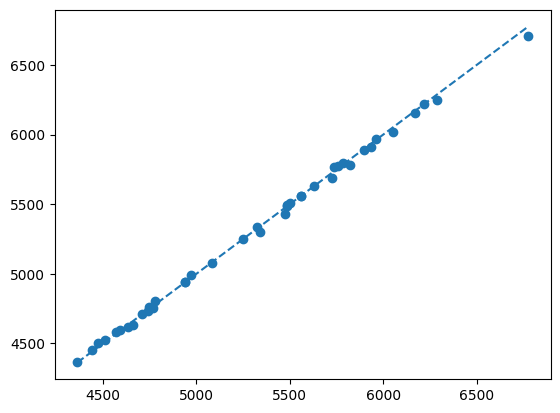

In [ ]:
# Scatter plot of true vs predicted values
plt.scatter(y_test, y_pred)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()], '--')
